In [1]:
import os
import time
import random
import warnings
import typing as tp
import pathlib
from contextlib import contextmanager

import cv2
import librosa

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

In [2]:
import python_speech_features as psf
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
data_path = pathlib.Path("../data")

In [4]:
train = pd.read_csv(data_path/'Train.csv')
train.head()

,fn,label
0,audio_files/IV38R7F.wav,akawuka
1,audio_files/KM4SKWT.wav,banana
2,audio_files/F5POSU9.wav,obulwadde
3,audio_files/MMVDXG2.wav,nnyaanya
4,audio_files/9TVM96F.wav,pampu


In [5]:
train_extra = pd.read_csv(data_path/'train_add.csv')
train_extra.head(3)

,fn,label
0,audio_files_full/3d43af6faf2244c288154dc4ff6a7...,obuwuka
1,audio_files_full/3d43af6faf2244c288154dc4ff6a7...,obuwuka
2,audio_files_full/744b1a437234489fae9512694d221...,obuwuka


In [6]:
train_extra_2 = pd.read_csv(data_path/'train_add_20201029.csv')
train_extra_2.head(3)

,fn,label
0,audio_files_full_20201029/2497942026ef4d7e97d4...,obuwuka
1,audio_files_full_20201029/d027264654b94950aeb2...,ejjobyo
2,audio_files_full_20201029/d027264654b94950aeb2...,ejjobyo


In [7]:
label2code = {word: idx for idx, word in enumerate(train.label.unique().tolist())}
code2label = {v:k for k,v in label2code.items()}

In [8]:
audios_path = data_path / "all_audio_resampled"

In [9]:
def get_image_path(audio_path):
    file_name = audio_path.split("/")[-1].split(".")[0]
    ip = str(audios_path.resolve() / f"{file_name}.wav")
    return ip

train["image_fn"] = train.fn.apply(get_image_path)
train_extra["image_fn"] = train_extra.fn.apply(get_image_path)
train_extra_2["image_fn"] = train_extra_2.fn.apply(get_image_path)

In [10]:
train_df = pd.concat([train, train_extra], axis=0).reset_index(drop=True)

In [11]:
### build validation that includes all classes:


vcs = train_df.label.value_counts()

## possible schema:
# 25+ - take 3
# 12-25 - take 2
# 12- - take 1

def num_for_val(num_examples):
    if num_examples >= 25:
        return 3
    if num_examples >= 12:
        return 2
    return 1

train_df["num_examples"] = train_df.label.map(vcs.to_dict())
train_df["num_for_val"] = train_df.num_examples.apply(num_for_val)

random.seed(12)
train_df_new = pd.DataFrame()
for label in train_df.label.unique():
    tmp = train_df.loc[train_df.label == label].copy()
    tmp["dummy"] = tmp.label.apply(lambda _: random.random())
    tmp.sort_values(by="dummy", inplace=True)
    tmp["rank"] = range(tmp.shape[0])
    train_df_new = pd.concat([train_df_new, tmp])

train_df_new.reset_index(drop=True, inplace=True)
train_df_new["val_subset"] = train_df_new.num_for_val > train_df_new["rank"]
train_df_new.drop("dummy", axis=1, inplace=True)

In [12]:
assert (
    set(train_df_new.loc[train_df_new.val_subset].label.unique()) == 
    set(train_df_new.loc[~train_df_new.val_subset].label.unique())
)

In [13]:
# from sklearn.model_selection import train_test_split

train_df, val_df = train_df_new.loc[~train_df_new.val_subset].copy(), train_df_new.loc[train_df_new.val_subset].copy()
print(train_df.shape)
print(val_df.shape)

(2500, 7)
(349, 7)


In [14]:
train_df = pd.concat([
    train_df.drop(["num_examples", "num_for_val", "rank", "val_subset"], axis=1),
    train_extra_2
]).reset_index(drop=True)

In [15]:
print(train_df.shape)
print(val_df.shape)

(4360, 3)
(349, 7)


In [16]:
## check no val leaking
assert train_df.merge(val_df, on=["image_fn"], how="inner").shape[0] == 0

### add part to make corrections to train & val:

In [17]:
# corrs = pd.read_csv(data_path / "2020_11_10_data_notes.tsv", sep="\t", header=None)
# corrs.columns = ["fn", "original_label", "comment", "verdict", "stuff", "stuff_2"]
# corrs.fn = corrs.fn.apply(lambda x: x + ".wav")

# corrs = corrs.loc[corrs.verdict.isin({"remove", "change label"})].reset_index(drop=True).copy()
# corrs["image_fn"] = corrs.fn.apply(get_image_path)

In [18]:
# train_df = train_df.merge(corrs[["image_fn", "verdict", "stuff"]], on=["image_fn"], how="left")

In [19]:
# rm_mask = (train_df.verdict == "remove")
# train_df = train_df.loc[~rm_mask].copy()

In [20]:
# change_label = (train_df.verdict == "change label")
# train_df.loc[change_label, "label"] = train_df.loc[change_label, "stuff"]

In [21]:
# val_df = val_df.merge(corrs[["image_fn", "verdict", "stuff"]], on=["image_fn"], how="left").copy()
# rm_mask = (val_df.verdict == "remove")
# val_df_filt = val_df.loc[~rm_mask].copy()

# print(val_df.shape)
# print(val_df_filt.shape)

### end part to make corrections to train & val

In [22]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, trg=None):
        if trg is None:
            for t in self.transforms:
                image = t(image)
            return image
        else:
            for t in self.transforms:
                image, trg = t(image, trg)
            return image, trg


class UseWithProb:
    def __init__(self, transform, prob=.5):
        self.transform = transform
        self.prob = prob

    def __call__(self, image, trg=None):
        if trg is None:
            if random.random() < self.prob:
                image = self.transform(image)
            return image
        else:
            if random.random() < self.prob:
                image, trg = self.transform(image, trg)
            return image, trg


class OneOf:
    def __init__(self, transforms, p=None):
        self.transforms = transforms
        self.p = p

    def __call__(self, image, trg=None):
        transform = np.random.choice(self.transforms, p=self.p)
        if trg is None:
            image = transform(image)
            return image
        else:
            image, trg = transform(image, trg)
            return image, trg

In [23]:
SR = 22050

In [24]:
class PitchShift:
    def __init__(self, pitch_range, sr=SR):
        self.pr_low, self.pr_hi = pitch_range
        self.sr=sr
    
    def __call__(self, audio):
        shift = np.random.choice(np.linspace(self.pr_low, self.pr_hi, 100))
        return librosa.effects.pitch_shift(audio, self.sr, shift)


class TimeStretch:
    def __init__(self, stretch_param):
        self.stretch = stretch_param
    
    def __call__(self, audio):
        """
        if self.stretch is one number, use it as stretch param.
        if it's 2nums array, use it as limits for uniform distribution
        from which we sample stretch param
        """
        if type(self.stretch) in (int, float):
            return librosa.effects.time_stretch(audio, self.stretch)
        else:
            low, hi = self.stretch
            s = np.random.choice(np.linspace(low, hi, 100))
            return librosa.effects.time_stretch(audio, s)
        
class AddNoise:
    def __init__(self, loc, scale):
        self.loc = loc
        self.scale = scale
        
    def __call__(self, audio):
        noise = np.random.normal(loc=self.loc, scale=self.scale, size=audio.shape)
        return noise + audio

In [25]:
def new_generate_spec(audio, config):
    arr_limit = int(config.max_len_sec * config.sr)

    # trim according to the config
    if config.trim:
        audio, trim_idx = librosa.effects.trim(audio)
#     print("audio shape", audio.shape)
    # for long audios: trim:
    if len(audio) >= arr_limit:
        audio = audio[:arr_limit]
    # for short: pad:
    else:
        
        to_add = arr_limit - len(audio)
        # pad either on the left:
        if not config.pad_center:
            audio = np.concatenate((np.zeros(to_add), audio))
        # or on both sides (simmetrically):
        else:
            add_l = to_add // 2
            add_r = to_add - add_l
            audio = np.concatenate((np.zeros(add_l), audio, np.zeros(add_r)))
    
    X = librosa.stft(audio, n_fft=config.n_fft, hop_length=config.hop_size)
    Xdb = librosa.amplitude_to_db(abs(X), ref=np.max)
    return Xdb


def new_build_image(audio, config):
    spec = new_generate_spec(audio, config)
    
    # Scale to (0, 255)
    spec  -= spec.min()
    spec *= 255.0/spec.max()

    # Make it uint8
    im_arr = np.array(spec, np.uint8)

    # Make it rgb (hint - some fun tricks you can do here!)
    r = im_arr
    g = im_arr
    b = im_arr
    
    image = np.stack([r, g, b], axis=-1)
    image = cv2.resize(image, (config.img_size, config.img_size))

    return image

In [26]:
import torchvision.transforms as tr
from PIL import Image

MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

def normalize(image, mean, std):
    image = (image / 255.0).astype(np.float32)
    image = (image - mean) / std
    return image

class SpectrogramDataset(data.Dataset):
    def __init__(
        self,
        file_list: tp.List[tp.List[str]],
        config,
        transform=None,
        normalize=True
    ):
        self.file_list = file_list  # list of list: [file_path, ebird_code]
#         self.img_size = img_size
        self.transform = transform
        self.normalize = normalize
#         self.audios_dict = audios_dict
        self.config = config

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        fn, word = self.file_list[idx]
        audio, _ = librosa.core.load(fn, sr=SR)
#         audio = self.audios_dict[fn]

        if self.transform:
            audio = self.transform(audio)

        image = new_build_image(audio, self.config)
        
        if self.normalize:
            norm_image = normalize(np.array(image), mean=MEAN, std=STD)
        else:
            norm_image = image
        
        return np.moveaxis(norm_image, 2, 0), label2code[word]
    
    
class SpectrogramTestDataset(data.Dataset):
    def __init__(
        self,
        file_list: tp.List[tp.List[str]],
        config,
        transform=None,
        normalize=True
    ):
        self.file_list = file_list  # list of list: [file_path, ebird_code]
#         self.img_size = img_size
        self.transform = transform
        self.normalize = normalize
#         self.audios_dict = audios_dict
        self.config = config

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        fn, word = self.file_list[idx]
        audio, _ = librosa.core.load(fn, sr=SR)
#         audio = self.audios_dict[fn]

        if self.transform:
            audio = self.transform(audio)

        image = new_build_image(audio, self.config)
        
        if self.normalize:
            norm_image = normalize(np.array(image), mean=MEAN, std=STD)
        else:
            norm_image = image
        
        return np.moveaxis(norm_image, 2, 0)

In [27]:
# import torchvision.transforms as tr


# aug_noise = AddNoise(0, 0.07)
# aug_ts = TimeStretch((0.5, 2))
# aug_pitch = PitchShift((-5, 5))

# train_transforms = OneOf([
#     aug_noise,
#     aug_ts,
#     aug_pitch
# ])

class AudioConfig:
    n_fft = 1024
    hop_size = 256
    pad_center = True
    trim = True
    max_len_sec = 3 #1 if trim else 2.5
    sr = 22050
    img_size = 299
    
conf = AudioConfig()

In [28]:
sdf_train = SpectrogramDataset(train_df[["image_fn", "label"]].values.tolist(), conf, normalize=True)
sdf_val = SpectrogramDataset(val_df[["image_fn", "label"]].values.tolist(), conf, normalize=True)
# sdf_val_filt = SpectrogramDataset(val_df_filt[["image_fn", "label"]].values.tolist(), conf, normalize=True)

In [29]:
# Source: https://www.kaggle.com/mhiro2/simple-2d-cnn-classifier-with-pytorch
import torch
from torch import nn
import torch.nn.functional as F


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.avg_pool2d(x, 2)
        return x


class SimpleKaggle(nn.Module):
    def __init__(self, num_classes, base_size=64, dropout=0.2):
        super().__init__()

        self.conv = nn.Sequential(
            ConvBlock(in_channels=3, out_channels=base_size),
            ConvBlock(in_channels=base_size, out_channels=base_size*2),
            ConvBlock(in_channels=base_size*2, out_channels=base_size*4),
            ConvBlock(in_channels=base_size*4, out_channels=base_size*8),
        )

        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_size*8, base_size*2),
            nn.PReLU(),
            nn.BatchNorm1d(base_size*2),
            nn.Dropout(dropout/2),
            nn.Linear(base_size*2, num_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.mean(x, dim=3)
        x, _ = torch.max(x, dim=2)
        x = self.fc(x)
        return x

In [30]:
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, models, transforms

# model_ft = models.resnet101(pretrained=True)
# model_ft = models.resnet50(pretrained=True)
# print(model_ft.fc.in_features)

n_classes = len(label2code)

# model_ft.fc = nn.Sequential(
#     nn.Linear(model_ft.fc.in_features, n_classes)
# )
model_ft = SimpleKaggle(n_classes)

device = torch.device("cuda")

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss(reduction="sum")

optimizer_ft = optim.Adam(model_ft.parameters(), lr=2e-4)

In [31]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(optimizer_ft, 'min', patience=4, factor=0.5, verbose=True, min_lr=3e-5)

In [32]:
def train_epoch(log_interval, model, device, criterion, train_loader, optimizer, epoch):
#     print(epoch)
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.type(torch.FloatTensor).to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return loss.item()

            
def test(model, device, criterion, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.type(torch.FloatTensor).to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

    return test_loss, accuracy

In [33]:
train_loader = torch.utils.data.DataLoader(sdf_train, batch_size=32, shuffle=True,
                                           num_workers=4, drop_last=False, pin_memory=True) ## ADDED shuffle
val_loader = torch.utils.data.DataLoader(sdf_val, batch_size=32, drop_last=False, pin_memory=True)
# val_filt_loader = torch.utils.data.DataLoader(sdf_val_filt, batch_size=32, drop_last=False, pin_memory=True)

In [34]:
test(model_ft, device, criterion, val_loader)


Test set: Average loss: 5.3282, Accuracy: 3/349 (1%)



(5.328178821115576, 0.8595988538681948)

In [35]:
# test(model_ft, device, criterion, val_filt_loader)

In [36]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [37]:
t0 = time.time()
alphabet = "abcdefghijklmnopqrstuvwxyz"
tmp_folder_name = "REPR_simple_kaggle_spec_exp"

best_loss = 1e5
best_acc = 0

max_patience = 20
patience = 0
os.mkdir(f"tmp/{tmp_folder_name}")

train_loss_hist = list()
val_loss_hist = list()
val_acc_hist = list()
# val_loss_hist_filt = list()
# val_acc_hist_filt = list()

save_each_epoch = False

set_seed(9)


for ep in range(75):
    train_loss = train_epoch(1e10, model_ft, device, criterion, train_loader, optimizer_ft, ep)
    cur_loss, cur_acc = test(model_ft, device, criterion, val_loader)
    
    train_loss_hist.append(train_loss)
    val_loss_hist.append(cur_loss)
    val_acc_hist.append(cur_acc)
    
    if save_each_epoch:
        torch.save(model_ft.state_dict(), f"tmp/{tmp_folder_name}/model_ep_{ep}.pth")

    if cur_loss < best_loss:
        torch.save(model_ft.state_dict(), f"tmp/{tmp_folder_name}/best_run.pth")
        best_loss = cur_loss
        best_acc = cur_acc
        patience = 0
    else:
        patience += 1
        print("patience:", patience)
#         if patience > max_patience:
#             break

    lr_scheduler.step(cur_loss) ## removed lr scheduler for now
    print("Training so far {} minutes".format((time.time() - t0) / 60))
    print("="*20)

print("time spent training: {} minutes".format((time.time() - t0) / 60))

Train Epoch: 0 [0/4360 (0%)]	Loss: 176.974762

Test set: Average loss: 5.2703, Accuracy: 8/349 (2%)

Training so far 1.1458705186843872 minutes
Train Epoch: 1 [0/4360 (0%)]	Loss: 154.253250

Test set: Average loss: 4.7784, Accuracy: 20/349 (6%)

Training so far 2.2870932777722675 minutes
Train Epoch: 2 [0/4360 (0%)]	Loss: 144.406921

Test set: Average loss: 4.5467, Accuracy: 23/349 (7%)

Training so far 3.436076537768046 minutes
Train Epoch: 3 [0/4360 (0%)]	Loss: 132.129654

Test set: Average loss: 4.3442, Accuracy: 49/349 (14%)

Training so far 4.587446661790212 minutes
Train Epoch: 4 [0/4360 (0%)]	Loss: 117.118752

Test set: Average loss: 3.9349, Accuracy: 62/349 (18%)

Training so far 5.74212201833725 minutes
Train Epoch: 5 [0/4360 (0%)]	Loss: 107.053726

Test set: Average loss: 3.3750, Accuracy: 111/349 (32%)

Training so far 6.897589282194773 minutes
Train Epoch: 6 [0/4360 (0%)]	Loss: 83.427567

Test set: Average loss: 3.2950, Accuracy: 129/349 (37%)

Training so far 8.04957080284


Test set: Average loss: 0.8365, Accuracy: 284/349 (81%)

patience: 6
Training so far 55.42299674749374 minutes
Train Epoch: 48 [0/4360 (0%)]	Loss: 0.242958

Test set: Average loss: 0.8343, Accuracy: 285/349 (82%)

patience: 7
Training so far 56.57912106513977 minutes
Train Epoch: 49 [0/4360 (0%)]	Loss: 0.233240

Test set: Average loss: 0.8445, Accuracy: 281/349 (81%)

patience: 8
Training so far 57.7353971362114 minutes
Train Epoch: 50 [0/4360 (0%)]	Loss: 0.281996

Test set: Average loss: 0.8433, Accuracy: 283/349 (81%)

patience: 9
Training so far 58.89131880203883 minutes
Train Epoch: 51 [0/4360 (0%)]	Loss: 0.211189

Test set: Average loss: 0.8367, Accuracy: 283/349 (81%)

patience: 10
Epoch    52: reducing learning rate of group 0 to 3.0000e-05.
Training so far 60.04624349276225 minutes
Train Epoch: 52 [0/4360 (0%)]	Loss: 0.212462

Test set: Average loss: 0.8361, Accuracy: 282/349 (81%)

patience: 11
Training so far 61.20140066544215 minutes
Train Epoch: 53 [0/4360 (0%)]	Loss: 0.18

In [38]:
# print("time spent training: {} minutes".format((time.time() - t0) / 60))

In [39]:
# torch.save(model_ft.state_dict(), f"tmp/{tmp_folder_name}/model_ep_{ep}.pth")


In [40]:
# torch.save(model_ft.state_dict(), f"resnet18_ep30.pth")
print(min(val_loss_hist))
print(best_loss)

0.828887540494815
0.828887540494815


In [41]:
tmp_folder_name

'REPR_simple_kaggle_spec_exp'

In [42]:
print(max(val_acc_hist) / 100)
print(best_acc / 100)

0.8252148997134671
0.816618911174785


In [43]:
import matplotlib.pyplot as plt

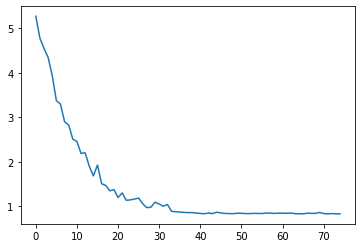

In [44]:
plt.plot(range(len(val_loss_hist)), val_loss_hist)

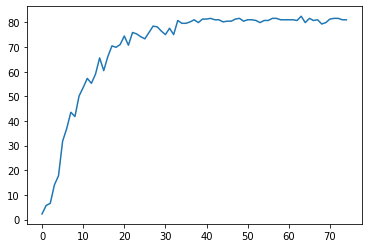

In [45]:
plt.plot(range(len(val_acc_hist)), val_acc_hist)

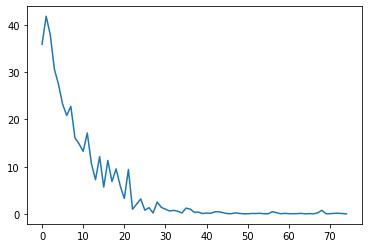

In [46]:
plt.plot(range(len(train_loss_hist)), train_loss_hist)

In [47]:
model_ft.load_state_dict(torch.load(f"tmp/{tmp_folder_name}/best_run.pth"))

<All keys matched successfully>

In [48]:
## try inference:
test_loader = torch.utils.data.DataLoader(sdf_val, batch_size=16)

In [49]:
%%time

sfm = nn.Softmax()
predictions = list()

for batch_idx, (inputs, _) in enumerate(test_loader):
    inputs = inputs.type(torch.FloatTensor).to(device)

    # forward
    # track history if only in train
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        predictions.append(sfm(outputs)) ## ADD SOFTMAX

predictions = np.concatenate([t.cpu().numpy() for t in predictions])
preds = np.argmax(predictions, axis=1)

/home/letfoolsdie/virtual_envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


CPU times: user 4.52 s, sys: 194 ms, total: 4.72 s
Wall time: 3.53 s


In [50]:
val_df["preds"] = [code2label[c] for c in preds]

In [51]:
(val_df.label == val_df.preds).mean()

0.8166189111747851

## Prepare submission:

In [52]:
sample_subm = pd.read_csv("Submission1.csv")
sample_subm.head(3)

,fn,maize streak virus,disease,okukkoola,muwogo,mpeke,mucungwa,greens,garden,mango,...,kasaanyi,suckers,insects,fertilizer,nakavundira,ekiwojjolo,akawuka,ddagala,ebiwojjolo,obutungulu
0,audio_files/00118N3.wav,0.002769,0.002084,0.005227,0.002884,0.004507,0.003533,0.001687,0.001626,0.003026,...,0.001507,0.002586,0.000081,0.000787,0.001928,0.004070,0.000132,0.000324,0.003241,0.003494
1,audio_files/00P0NMV.wav,0.001113,0.006091,0.001480,0.005104,0.004039,0.001252,0.000326,0.009214,0.000750,...,0.002991,0.001708,0.001014,0.000887,0.218384,0.002322,0.026944,0.014598,0.005134,0.004125
2,audio_files/01QEEZI.wav,0.001245,0.003642,0.001077,0.005952,0.006379,0.003655,0.002700,0.002457,0.000995,...,0.007273,0.005435,0.000962,0.002200,0.001465,0.001184,0.000905,0.000909,0.000670,0.001558


In [53]:
sample_subm["image_fn"] = sample_subm.fn.apply(get_image_path)

In [54]:
sample_subm.head(3)

,fn,maize streak virus,disease,okukkoola,muwogo,mpeke,mucungwa,greens,garden,mango,...,suckers,insects,fertilizer,nakavundira,ekiwojjolo,akawuka,ddagala,ebiwojjolo,obutungulu,image_fn
0,audio_files/00118N3.wav,0.002769,0.002084,0.005227,0.002884,0.004507,0.003533,0.001687,0.001626,0.003026,...,0.002586,0.000081,0.000787,0.001928,0.004070,0.000132,0.000324,0.003241,0.003494,/home/letfoolsdie/zindi_nlp/data/all_audio_res...
1,audio_files/00P0NMV.wav,0.001113,0.006091,0.001480,0.005104,0.004039,0.001252,0.000326,0.009214,0.000750,...,0.001708,0.001014,0.000887,0.218384,0.002322,0.026944,0.014598,0.005134,0.004125,/home/letfoolsdie/zindi_nlp/data/all_audio_res...
2,audio_files/01QEEZI.wav,0.001245,0.003642,0.001077,0.005952,0.006379,0.003655,0.002700,0.002457,0.000995,...,0.005435,0.000962,0.002200,0.001465,0.001184,0.000905,0.000909,0.000670,0.001558,/home/letfoolsdie/zindi_nlp/data/all_audio_res...


In [55]:
def get_predictions(model, test_loader):
    sfm = nn.Softmax()
    predictions = list()
    for batch_idx, inputs in enumerate(test_loader):
        inputs = inputs.type(torch.FloatTensor).to(device)

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            predictions.append(sfm(outputs)) ## ADD SOFTMAX
    predictions = np.concatenate([t.cpu().numpy() for t in predictions])
    return predictions

In [56]:
subm_dataset = SpectrogramTestDataset([[path, None] for path in sample_subm.image_fn.values ], conf)
subm_loader = torch.utils.data.DataLoader(subm_dataset, batch_size=16)

In [57]:
%%time

preds = get_predictions(model_ft, subm_loader)

/home/letfoolsdie/virtual_envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


CPU times: user 13.4 s, sys: 658 ms, total: 14.1 s
Wall time: 10.4 s


In [58]:
print(preds.shape)

(1017, 193)


In [59]:
sample_subm.shape

(1017, 195)

In [60]:
%%time

for c in sample_subm.columns:
    if c in {"fn", "image_fn"}:
        continue
    c_idx = label2code[c]
    sample_subm[c] = preds[:, c_idx]

CPU times: user 37.6 ms, sys: 502 µs, total: 38.1 ms
Wall time: 37.6 ms


In [61]:
sample_subm.tail(3)

,fn,maize streak virus,disease,okukkoola,muwogo,mpeke,mucungwa,greens,garden,mango,...,suckers,insects,fertilizer,nakavundira,ekiwojjolo,akawuka,ddagala,ebiwojjolo,obutungulu,image_fn
1014,audio_files/ZSC69U3.wav,8.149199e-07,1.292392e-07,1.112196e-07,4.493209e-08,2.958854e-07,0.000002,3.251234e-07,4.019745e-07,6.517575e-07,...,0.000001,8.830582e-07,0.000002,0.000025,0.000051,0.000011,0.000012,0.000051,3.836421e-07,/home/letfoolsdie/zindi_nlp/data/all_audio_res...
1015,audio_files/ZU1I8MR.wav,1.874003e-06,8.202001e-06,1.476747e-05,1.142804e-03,1.334780e-04,0.000486,9.299334e-06,3.541032e-06,4.387319e-06,...,0.000002,2.208195e-05,0.000008,0.000115,0.000610,0.000055,0.000002,0.003195,1.925283e-03,/home/letfoolsdie/zindi_nlp/data/all_audio_res...
1016,audio_files/ZYO56VD.wav,8.708632e-06,2.683408e-06,4.515495e-07,7.280465e-08,8.039318e-06,0.000019,1.066791e-06,2.629088e-06,4.681643e-06,...,0.000007,4.856069e-06,0.000005,0.000001,0.000013,0.000012,0.000204,0.000002,1.531623e-08,/home/letfoolsdie/zindi_nlp/data/all_audio_res...


In [62]:
sample_subm.drop("image_fn", axis=1).to_csv('submissions/simple_kaggle_custom_spects.csv', index=False)